<a href="https://colab.research.google.com/github/aravindan155/AKumaranProjects/blob/main/UAE_smoking_ethnicity_outcomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload your '_cancer_dataset_uae.csv' file:
Please upload your CSV file...


Saving _cancer_dataset_uae.csv to _cancer_dataset_uae (1).csv
Uploaded _cancer_dataset_uae (1).csv (1727920 bytes)

Dataset Info:
Number of rows: 10000
Number of columns: 20

DataFrame created in Spark successfully!

Missing values in Ethnicity: 0
Missing values in Smoking_Status: 0
+-----------+-------------+----------+------+
|  Ethnicity|Former Smoker|Non-Smoker|Smoker|
+-----------+-------------+----------+------+
|   European|          362|       973|   648|
|       Arab|          432|       959|   592|
|    African|          337|      1044|   607|
|South Asian|          415|      1052|   616|
| East Asian|          371|      1010|   582|
+-----------+-------------+----------+------+


Percentage within each ethnicity group:
             Former Smoker  Non-Smoker  Smoker
Ethnicity                                     
European             18.26       59.36   89.30
Arab                 21.79       60.97   87.73
African              16.95       62.59   88.41
South Asian          19.9

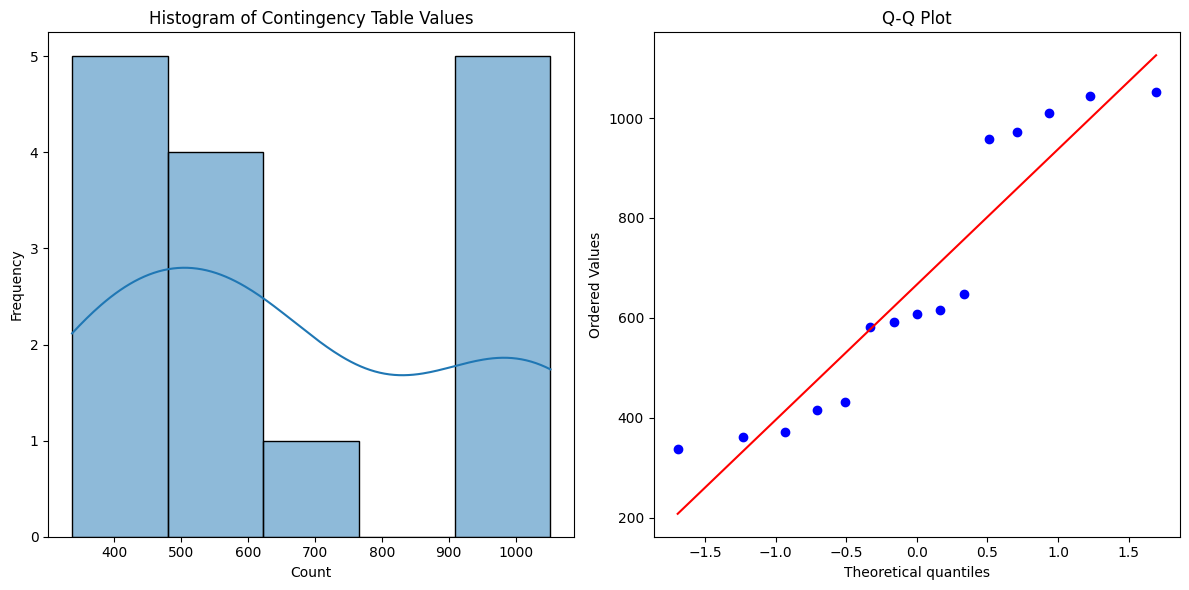


Overall assessment: Data is normally distributed.

STATISTICAL ANALYSIS

Traditional Chi-square test results:
Chi-square value: 22.6790
p-value: 0.003802
Degrees of freedom: 8
Association is statistically significant (α=0.05): True


<Figure size 1200x800 with 0 Axes>

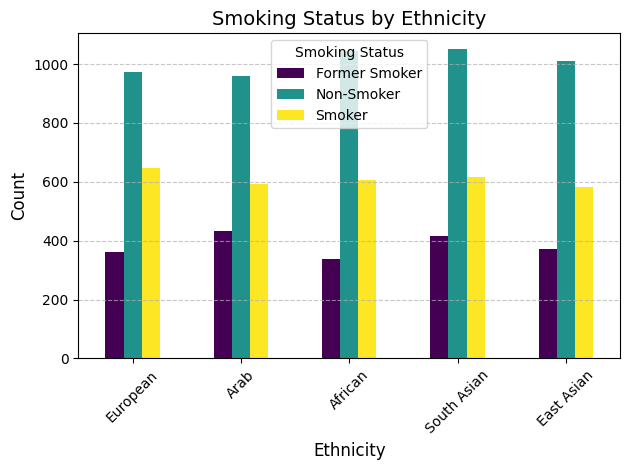

<Figure size 1200x800 with 0 Axes>

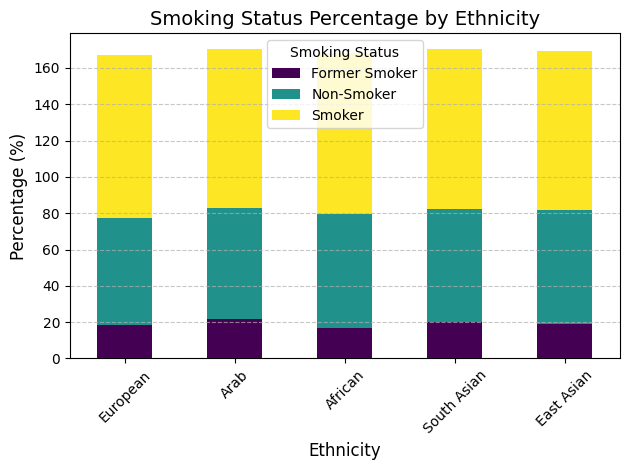

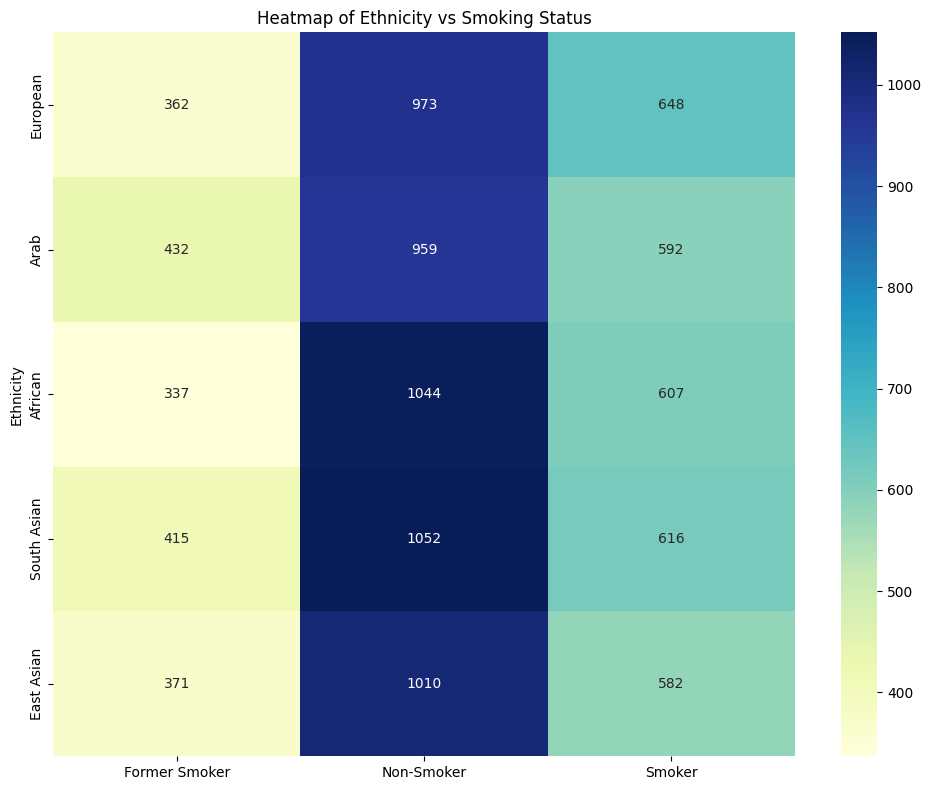


RESULTS EXPLANATION

Total counts for each ethnicity group:
European: 1983 individuals
Arab: 1983 individuals
African: 1988 individuals
South Asian: 2083 individuals
East Asian: 1963 individuals

Key Findings:
- European ethnicity has the highest smoking rate at 89.3%
- East Asian ethnicity has the lowest smoking rate at 87.7%
- East Asian ethnicity has the highest non-smoking rate at 62.7%
- Arab ethnicity has the highest former smoker rate at 21.8%

Statistical Analysis: The relationship between ethnicity and smoking status is
statistically significant (p-value = 0.003802 using traditional chi-square test).
This means that smoking habits are not distributed randomly across ethnic groups,
but rather show distinct patterns that vary by ethnicity.

Distribution Analysis: Our normality tests indicate that the data is
normally distributed, which is why we used
a traditional chi-square test for our analysis.


In [ ]:
# Ethnicity vs Smoking Status Analysis with Distribution Testing in Google Colab

# 1. SETUP AND DATA LOADING
# ------------------------------------------------------------------------

# Install PySpark if not already installed
!pip install pyspark scipy statsmodels

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, sum as spark_sum
import io
from google.colab import files
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Function to handle file upload
def get_csv_data():
    print("Please upload your CSV file...")
    uploaded = files.upload()  # This will prompt for file upload

    for filename in uploaded.keys():
        print(f"Uploaded {filename} ({len(uploaded[filename])} bytes)")
        # Create a pandas DataFrame from the uploaded file
        pandas_df = pd.read_csv(io.BytesIO(uploaded[filename]))
        return pandas_df, filename

    return None, None

# Create a Spark session
spark = SparkSession.builder \
    .appName("Ethnicity vs Smoking Status Analysis") \
    .getOrCreate()

# Get data
print("Please upload your '_cancer_dataset_uae.csv' file:")
df_pandas, filename = get_csv_data()

# Display basic information about the dataset
print("\nDataset Info:")
print(f"Number of rows: {df_pandas.shape[0]}")
print(f"Number of columns: {df_pandas.shape[1]}")

# Convert pandas DataFrame to Spark DataFrame
df = spark.createDataFrame(df_pandas)
print("\nDataFrame created in Spark successfully!")

# 2. DATA ANALYSIS
# ------------------------------------------------------------------------

# Check for missing values in our variables of interest
missing_ethnicity = df.filter(col("Ethnicity").isNull()).count()
missing_smoking = df.filter(col("Smoking_Status").isNull()).count()

print(f"\nMissing values in Ethnicity: {missing_ethnicity}")
print(f"Missing values in Smoking_Status: {missing_smoking}")

# Create cross-tabulation using Spark
cross_tab_spark = df.groupBy("Ethnicity").pivot("Smoking_Status").count().fillna(0)
cross_tab_spark.show()

# Convert Spark DataFrame to Pandas for visualization and statistical testing
cross_tab = cross_tab_spark.toPandas()
cross_tab = cross_tab.set_index("Ethnicity")

# Calculate total counts for each ethnicity
ethnicity_counts = df.groupBy("Ethnicity").count().toPandas()
ethnicity_counts = dict(zip(ethnicity_counts["Ethnicity"], ethnicity_counts["count"]))

# Calculate percentages within each ethnicity group
percentage_tab = cross_tab.copy()
for col_name in percentage_tab.columns:
    percentage_tab[col_name] = (percentage_tab[col_name] / percentage_tab.sum(axis=1)) * 100

print("\nPercentage within each ethnicity group:")
print(percentage_tab.round(2))

# 3. TESTING FOR NORMAL DISTRIBUTION
# ------------------------------------------------------------------------
print("\n" + "="*50)
print("DISTRIBUTION TESTING")
print("="*50)

# Convert the contingency table to a 1D array for normality tests
data_array = cross_tab.values.flatten()

# Perform normality tests
print("\nTesting if the data is normally distributed:")

# 1. Shapiro-Wilk test (for n < 2000)
shapiro_test = stats.shapiro(data_array)
print(f"Shapiro-Wilk Test: W={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.6f}")
print(f"Normally distributed according to Shapiro-Wilk: {shapiro_test.pvalue > 0.05}")

# 2. D'Agostino-Pearson test
k2, p_dagostino = stats.normaltest(data_array)
print(f"D'Agostino-Pearson Test: k²={k2:.4f}, p-value={p_dagostino:.6f}")
print(f"Normally distributed according to D'Agostino-Pearson: {p_dagostino > 0.05}")

# 3. Kolmogorov-Smirnov test
ks_test = stats.kstest(data_array, 'norm', args=(np.mean(data_array), np.std(data_array, ddof=1)))
print(f"Kolmogorov-Smirnov Test: D={ks_test.statistic:.4f}, p-value={ks_test.pvalue:.6f}")
print(f"Normally distributed according to Kolmogorov-Smirnov: {ks_test.pvalue > 0.05}")

# Visualize the distribution
plt.figure(figsize=(12, 6))

# Histogram with normal curve
plt.subplot(1, 2, 1)
sns.histplot(data_array, kde=True)
plt.title('Histogram of Contingency Table Values')
plt.xlabel('Count')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(data_array, plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

# Determine if data is normally distributed (if at least 2 tests agree)
is_normal = sum([
    shapiro_test.pvalue > 0.05,
    p_dagostino > 0.05,
    ks_test.pvalue > 0.05
]) >= 2

print(f"\nOverall assessment: Data is {'normally' if is_normal else 'not normally'} distributed.")

# 4. STATISTICAL ANALYSIS
# ------------------------------------------------------------------------
print("\n" + "="*50)
print("STATISTICAL ANALYSIS")
print("="*50)

# Traditional Chi-Square Test
chi2, p, dof, expected = chi2_contingency(cross_tab)
print("\nTraditional Chi-square test results:")
print(f"Chi-square value: {chi2:.4f}")
print(f"p-value: {p:.6f}")
print(f"Degrees of freedom: {dof}")
print(f"Association is statistically significant (α=0.05): {p < 0.05}")

# For non-normal data, we can use a Monte Carlo simulation approach to chi-square
if not is_normal:
    # Monte Carlo simulation for chi-square
    chi2, p_mc, dof, expected = chi2_contingency(cross_tab, simulate_p_value=True, iterations=10000)
    print("\nNon-parametric Chi-square test (Monte Carlo simulation):")
    print(f"Chi-square value: {chi2:.4f}")
    print(f"Monte Carlo p-value: {p_mc:.6f}")
    print(f"Degrees of freedom: {dof}")
    print(f"Association is statistically significant (α=0.05): {p_mc < 0.05}")

    # Fisher's exact test for small sample sizes or sparse tables
    if cross_tab.shape[0] <= 5 and cross_tab.shape[1] <= 5:
        from scipy.stats import fisher_exact

        # For 2x2 tables only
        if cross_tab.shape[0] == 2 and cross_tab.shape[1] == 2:
            odds_ratio, p_fisher = fisher_exact(cross_tab)
            print("\nFisher's exact test results (for 2x2 tables):")
            print(f"Odds ratio: {odds_ratio:.4f}")
            print(f"p-value: {p_fisher:.6f}")
            print(f"Association is statistically significant (α=0.05): {p_fisher < 0.05}")
        else:
            print("\nNote: Fisher's exact test is only calculated for 2x2 tables.")
    else:
        print("\nNote: Fisher's exact test was not performed due to table dimensions.")

# 5. VISUALIZATIONS
# ------------------------------------------------------------------------

# Create a visualization
plt.figure(figsize=(12, 8))

# Create the grouped bar chart
cross_tab.plot(kind='bar', stacked=False, colormap='viridis')

# Add labels and title
plt.xlabel('Ethnicity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Smoking Status by Ethnicity', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Smoking Status')

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# Create a percentage stacked bar chart
plt.figure(figsize=(12, 8))

# Plot stacked percentage bar chart
percentage_tab.plot(kind='bar', stacked=True, colormap='viridis')

# Add labels and title
plt.xlabel('Ethnicity', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Smoking Status Percentage by Ethnicity', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Smoking Status')

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# Additional visualization: Heatmap of the counts
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Heatmap of Ethnicity vs Smoking Status')
plt.tight_layout()
plt.show()

# 6. RESULTS EXPLANATION
# ------------------------------------------------------------------------

print("\n" + "="*50)
print("RESULTS EXPLANATION")
print("="*50)

# Print total counts for each ethnicity group
print(f"\nTotal counts for each ethnicity group:")
for ethnicity, count in ethnicity_counts.items():
    print(f"{ethnicity}: {count} individuals")

# Get the ethnicity with highest smoking prevalence
if 'Smoker' in percentage_tab.columns:
    smoking_prevalence = percentage_tab['Smoker'].sort_values(ascending=False)
    highest_smoking = smoking_prevalence.index[0]
    highest_pct = smoking_prevalence.iloc[0]
    lowest_smoking = smoking_prevalence.index[-1]
    lowest_pct = smoking_prevalence.iloc[-1]

    print("\nKey Findings:")
    print(f"- {highest_smoking} ethnicity has the highest smoking rate at {highest_pct:.1f}%")
    print(f"- {lowest_smoking} ethnicity has the lowest smoking rate at {lowest_pct:.1f}%")

# Get the ethnicity with highest non-smoking prevalence
if 'Non-Smoker' in percentage_tab.columns:
    nonsmoking_prevalence = percentage_tab['Non-Smoker'].sort_values(ascending=False)
    highest_nonsmoking = nonsmoking_prevalence.index[0]
    highest_nonsmoking_pct = nonsmoking_prevalence.iloc[0]
    print(f"- {highest_nonsmoking} ethnicity has the highest non-smoking rate at {highest_nonsmoking_pct:.1f}%")

# Get the ethnicity with highest former smoker prevalence
if 'Former Smoker' in percentage_tab.columns:
    former_prevalence = percentage_tab['Former Smoker'].sort_values(ascending=False)
    highest_former = former_prevalence.index[0]
    highest_former_pct = former_prevalence.iloc[0]
    print(f"- {highest_former} ethnicity has the highest former smoker rate at {highest_former_pct:.1f}%")

# Statistical significance explanation
p_value = p_mc if not is_normal else p
test_type = "non-parametric chi-square test with Monte Carlo simulation" if not is_normal else "traditional chi-square test"

if p_value < 0.05:
    print(f"\nStatistical Analysis: The relationship between ethnicity and smoking status is")
    print(f"statistically significant (p-value = {p_value:.6f} using {test_type}).")
    print(f"This means that smoking habits are not distributed randomly across ethnic groups,")
    print(f"but rather show distinct patterns that vary by ethnicity.")
else:
    print(f"\nStatistical Analysis: The relationship between ethnicity and smoking status is")
    print(f"not statistically significant (p-value = {p_value:.6f} using {test_type}).")
    print(f"This suggests that smoking habits are distributed similarly across all ethnic")
    print(f"groups in this dataset.")

print("\nDistribution Analysis: Our normality tests indicate that the data is")
print(f"{'normally' if is_normal else 'not normally'} distributed, which is why we used")
print(f"a {test_type} for our analysis.")

# Stop the Spark session
spark.stop()

LOADING DATA
For Google Colab, you can either upload the file directly or provide the path.
Default path for uploaded files: '_cancer_dataset_uae.csv'
If using from Google Drive, first mount your drive with:
from google.colab import drive
drive.mount('/content/drive')
Then use path like: '/content/drive/My Drive/_cancer_dataset_uae.csv'
Choose data loading method:
1. Upload CSV file
2. Use file path
Enter your choice (1 or 2): 1
Please upload your CSV file...


Saving _cancer_dataset_uae.csv to _cancer_dataset_uae (2).csv
Uploaded _cancer_dataset_uae (2).csv (1727920 bytes)

Dataset Info:
Number of rows: 10000
Number of columns: 20

Checking expected variable values:
Ethnicity unique values: ['European' 'South Asian' 'African' 'East Asian' 'Arab']
Smoking_Status unique values: ['Non-Smoker' 'Smoker' 'Former Smoker']
Cancer_Type unique values: ['Liver' 'Leukemia' 'Lung' 'Pancreatic' 'Breast' 'Ovarian' 'Prostate'
 'Colorectal']
Cancer_Stage unique values: ['II' 'III' 'I' 'IV']
Treatment_Type unique values: ['Radiation' 'Surgery' 'Chemotherapy' 'Immunotherapy']
Outcome unique values: ['Recovered' 'Under Treatment' 'Deceased']

DataFrame created in Spark successfully!

CREATING COMBINED VARIABLES

ANALYSIS 1: ETHNICITY-SMOKING VS CANCER TYPE

Contingency Table (Ethnicity_Smoking vs Cancer_Type):
Cancer_Type                Breast  Colorectal  Leukemia  Liver  Lung  Ovarian  \
Ethnicity_Smoking                                                       

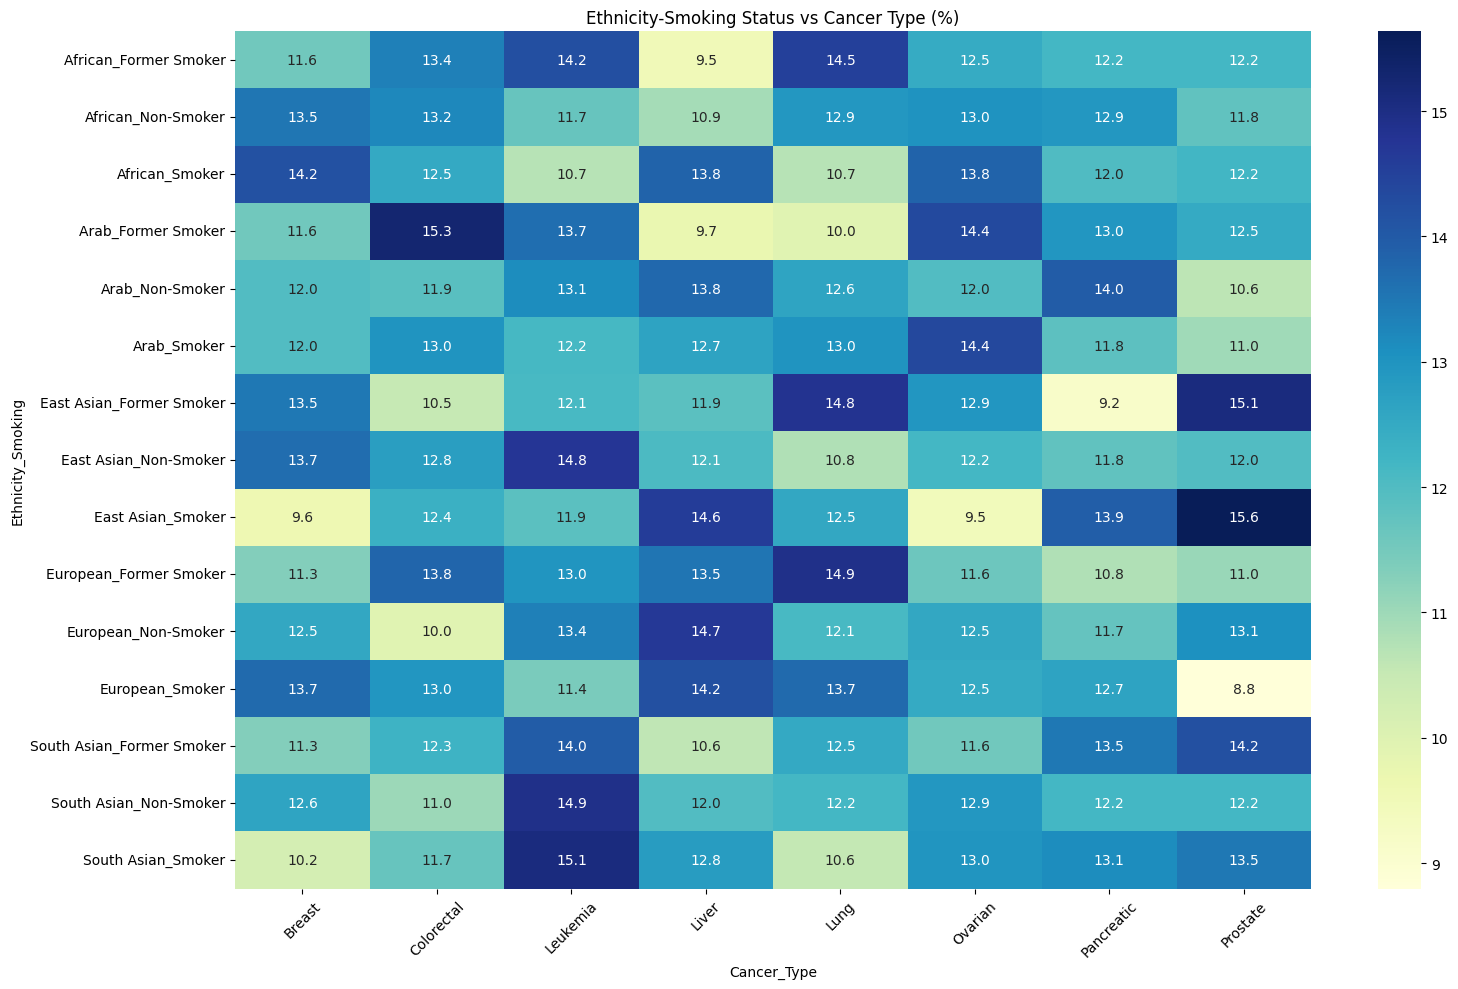


-------------------- Ethnicity-Smoking Status vs Cancer Type --------------------

Testing if the data is normally distributed:
Shapiro-Wilk Test: W=0.9222, p-value=0.000003
Normally distributed according to Shapiro-Wilk: False
D'Agostino-Pearson Test: k²=48.0479, p-value=0.000000
Normally distributed according to D'Agostino-Pearson: False
Kolmogorov-Smirnov Test: D=0.1257, p-value=0.041208
Normally distributed according to Kolmogorov-Smirnov: False


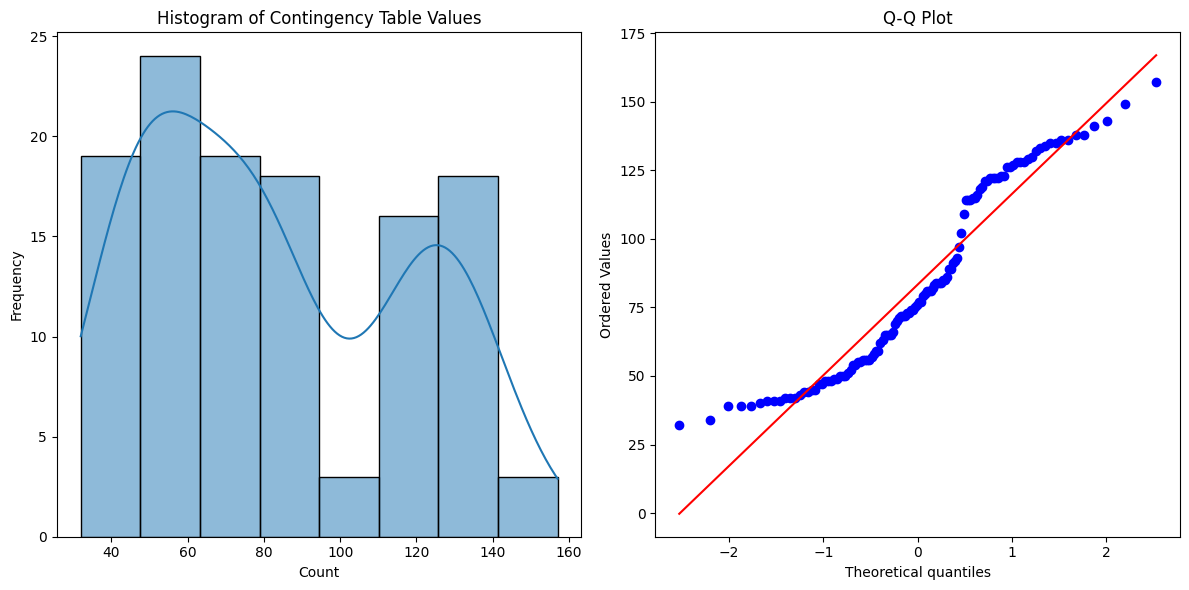


Overall assessment: Data is not normally distributed.

Traditional Chi-square test results:
Chi-square value: 109.8515
p-value: 0.194394
Degrees of freedom: 98
Association is statistically significant (α=0.05): False
Non-parametric Chi-square test failed: chi2_contingency() got an unexpected keyword argument 'simulate_p_value'

Conclusion: Using traditional chi-square test, the association is not statistically significant
(p-value = 0.194394, α=0.05)

ANALYSIS 2: CANCER TYPE VS CANCER STAGE

Contingency Table (Cancer_Type vs Cancer_Stage):
Cancer_Stage    I   II  III   IV
Cancer_Type                     
Breast        311  380  367  183
Colorectal    295  357  379  195
Leukemia      331  408  394  181
Liver         304  388  398  173
Lung          309  361  376  187
Ovarian       267  390  393  209
Pancreatic    312  380  367  184
Prostate      290  372  367  192

Percentage Table (row percentages):
Cancer_Stage      I     II    III     IV
Cancer_Type                             
Brea

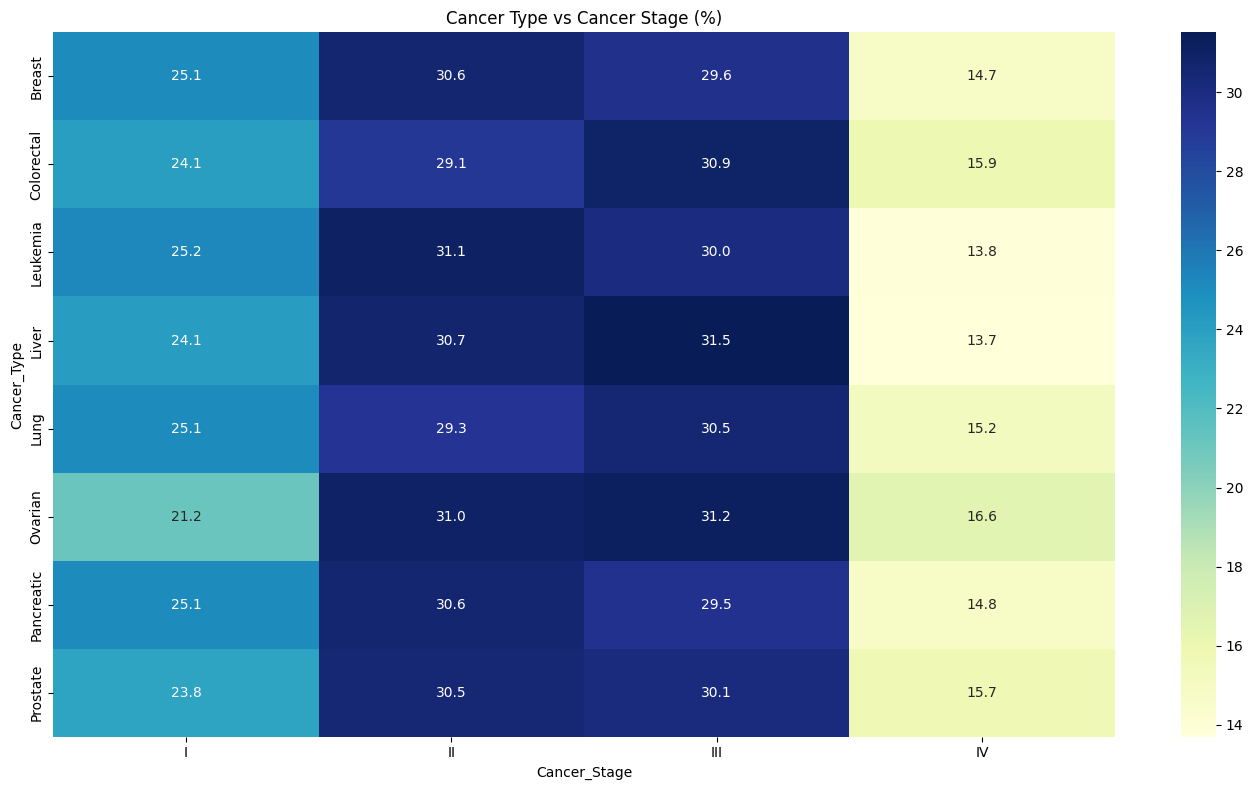

<Figure size 1400x800 with 0 Axes>

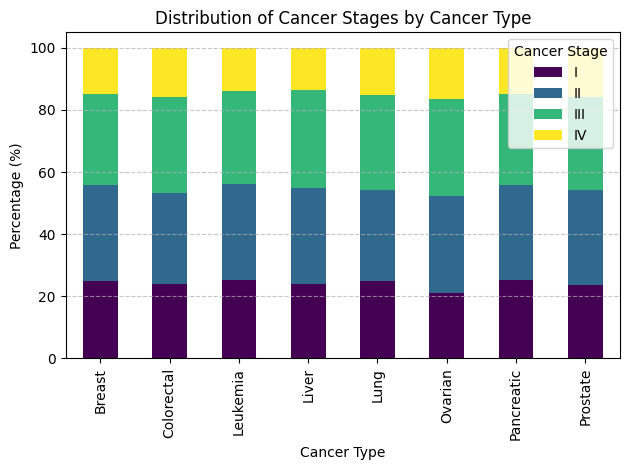


-------------------- Cancer Type vs Cancer Stage --------------------

Testing if the data is normally distributed:
Shapiro-Wilk Test: W=0.8437, p-value=0.000304
Normally distributed according to Shapiro-Wilk: False
D'Agostino-Pearson Test: k²=7.2943, p-value=0.026065
Normally distributed according to D'Agostino-Pearson: False
Kolmogorov-Smirnov Test: D=0.2085, p-value=0.106851
Normally distributed according to Kolmogorov-Smirnov: True


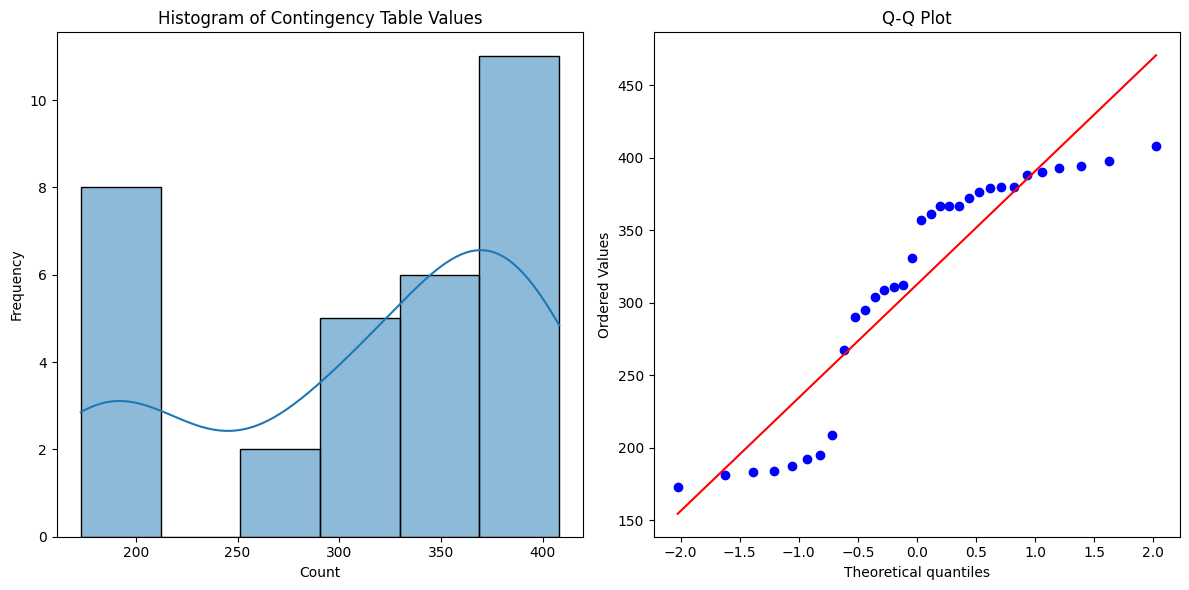


Overall assessment: Data is not normally distributed.

Traditional Chi-square test results:
Chi-square value: 15.7385
p-value: 0.784157
Degrees of freedom: 21
Association is statistically significant (α=0.05): False
Non-parametric Chi-square test failed: chi2_contingency() got an unexpected keyword argument 'simulate_p_value'

Conclusion: Using traditional chi-square test, the association is not statistically significant
(p-value = 0.784157, α=0.05)

ANALYSIS 3: CANCER TYPE-STAGE VS TREATMENT TYPE

Contingency Table (Cancer_Type_Stage vs Treatment_Type):
Treatment_Type        Chemotherapy  Immunotherapy  Radiation  Surgery
Cancer_Type_Stage                                                    
Breast_Stage_I                  82             72         82       75
Breast_Stage_II                 99             89         98       94
Breast_Stage_III                95             85         87      100
Breast_Stage_IV                 47             44         49       43
Colorectal_Stage_I

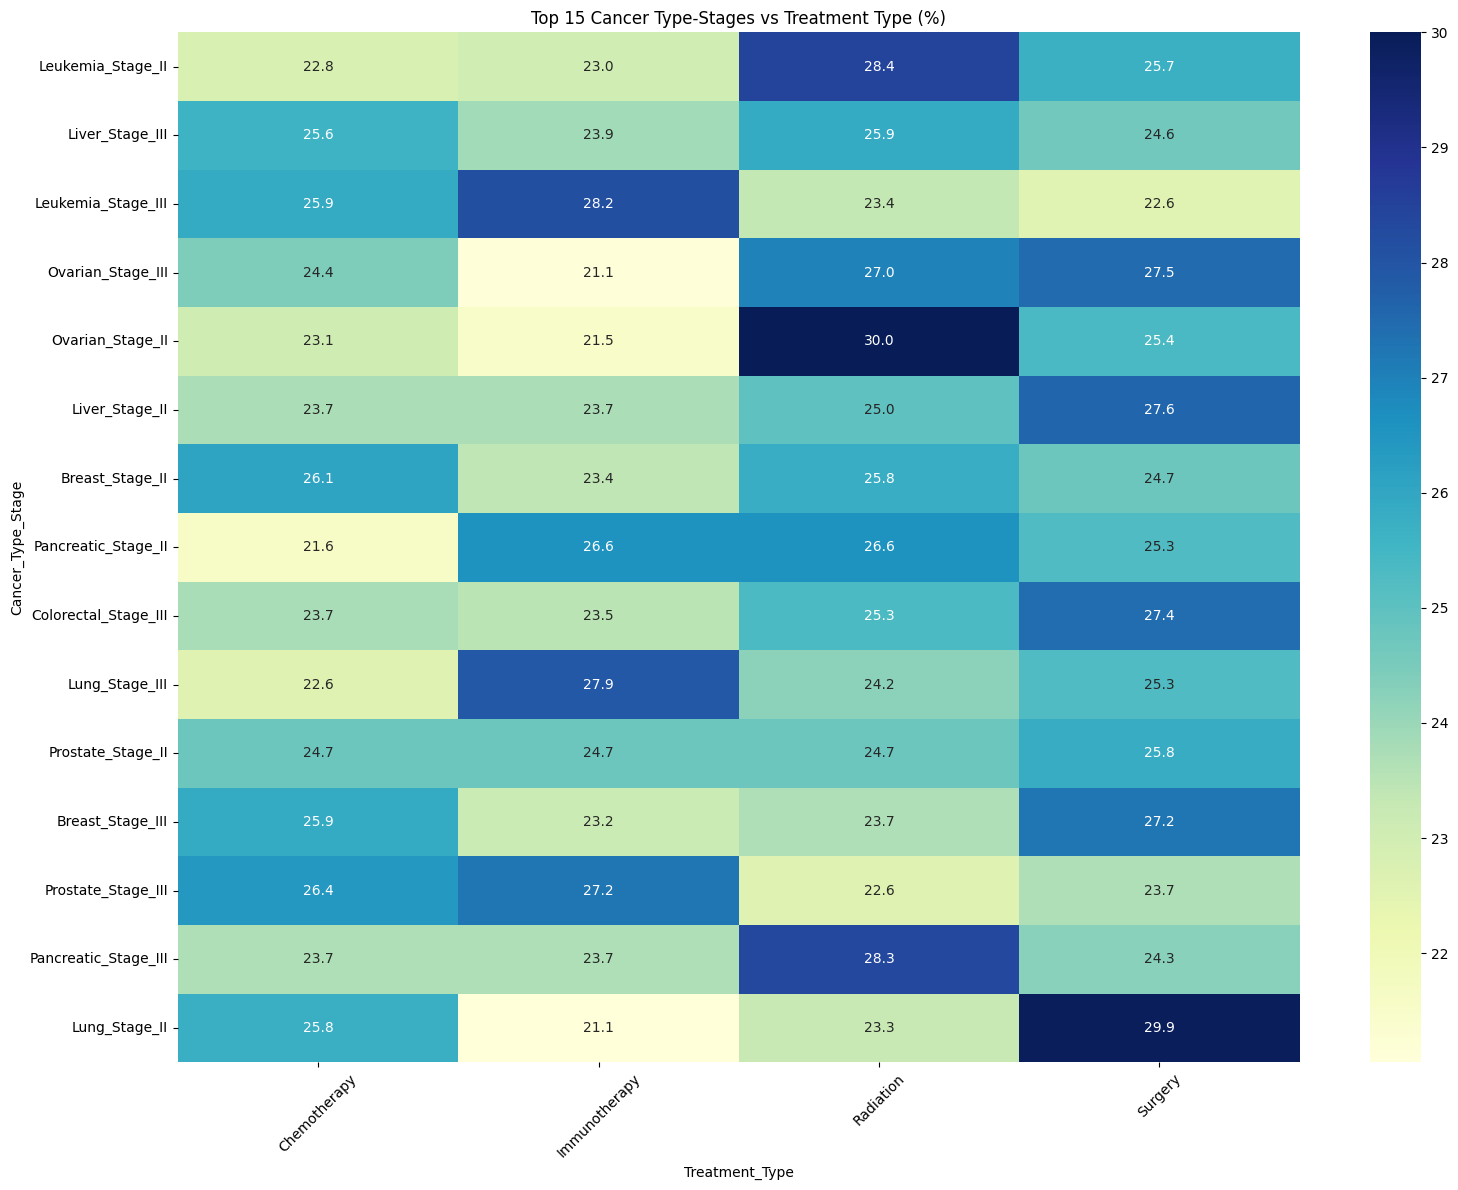


-------------------- Cancer Type-Stage vs Treatment Type --------------------

Testing if the data is normally distributed:
Shapiro-Wilk Test: W=0.9386, p-value=0.000019
Normally distributed according to Shapiro-Wilk: False
D'Agostino-Pearson Test: k²=19.9078, p-value=0.000048
Normally distributed according to D'Agostino-Pearson: False
Kolmogorov-Smirnov Test: D=0.1393, p-value=0.012509
Normally distributed according to Kolmogorov-Smirnov: False


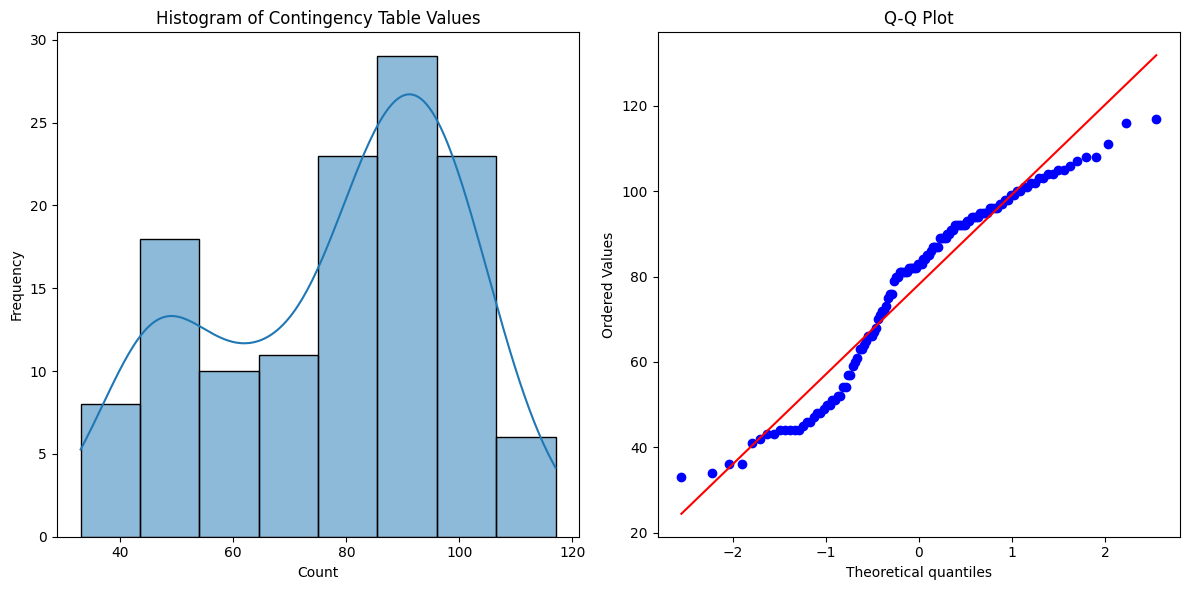


Overall assessment: Data is not normally distributed.

Traditional Chi-square test results:
Chi-square value: 95.6969
p-value: 0.403361
Degrees of freedom: 93
Association is statistically significant (α=0.05): False
Non-parametric Chi-square test failed: chi2_contingency() got an unexpected keyword argument 'simulate_p_value'

Conclusion: Using traditional chi-square test, the association is not statistically significant
(p-value = 0.403361, α=0.05)

ANALYSIS 4: TREATMENT TYPE VS OUTCOME

Contingency Table (Treatment_Type vs Outcome):
Outcome         Deceased  Recovered  Under Treatment
Treatment_Type                                      
Chemotherapy         254       1226             1006
Immunotherapy        246       1256              995
Radiation            238       1232             1049
Surgery              254       1217             1027

Percentage Table (row percentages):
Outcome         Deceased  Recovered  Under Treatment
Treatment_Type                                    

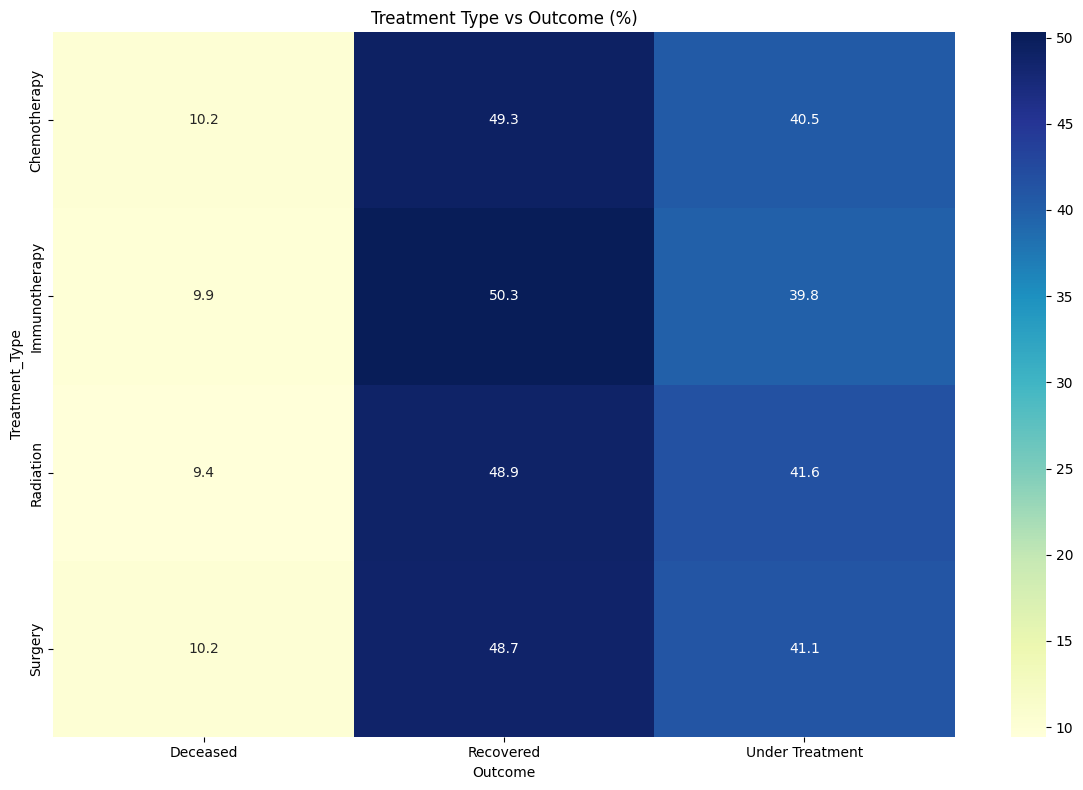

<Figure size 1200x800 with 0 Axes>

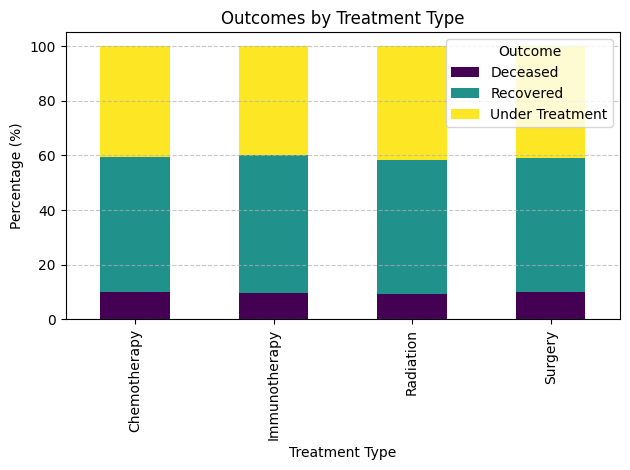


-------------------- Treatment Type vs Outcome --------------------

Testing if the data is normally distributed:
Shapiro-Wilk Test: W=0.7525, p-value=0.002835
Normally distributed according to Shapiro-Wilk: False
D'Agostino-Pearson Test: k²=4.7837, p-value=0.091459
Normally distributed according to D'Agostino-Pearson: True
Kolmogorov-Smirnov Test: D=0.3094, p-value=0.161756
Normally distributed according to Kolmogorov-Smirnov: True


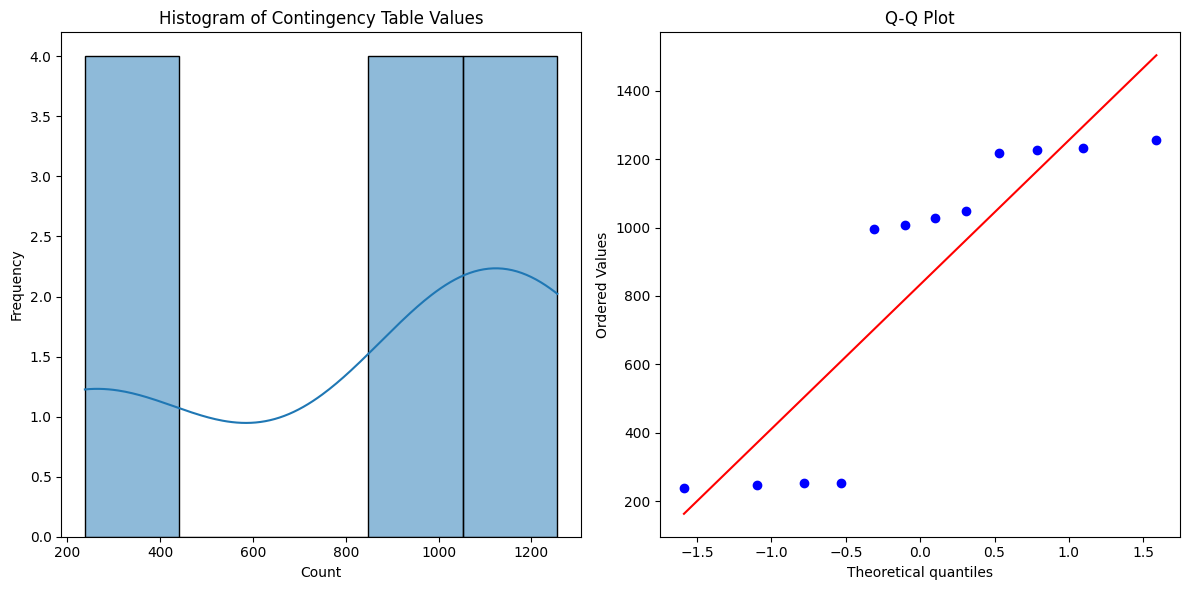


Overall assessment: Data is normally distributed.

Traditional Chi-square test results:
Chi-square value: 2.8299
p-value: 0.829873
Degrees of freedom: 6
Association is statistically significant (α=0.05): False

Conclusion: Using traditional chi-square test, the association is not statistically significant
(p-value = 0.829873, α=0.05)

FINAL ANALYSIS: ETHNICITY-SMOKING VS OUTCOME

Contingency Table (Ethnicity_Smoking vs Outcome):
Outcome                    Deceased  Recovered  Under Treatment
Ethnicity_Smoking                                              
African_Former Smoker            33        166              138
African_Non-Smoker               81        540              423
African_Smoker                   49        297              261
Arab_Former Smoker               51        205              176
Arab_Non-Smoker                  98        488              373
Arab_Smoker                      61        286              245
East Asian_Former Smoker         29        188        

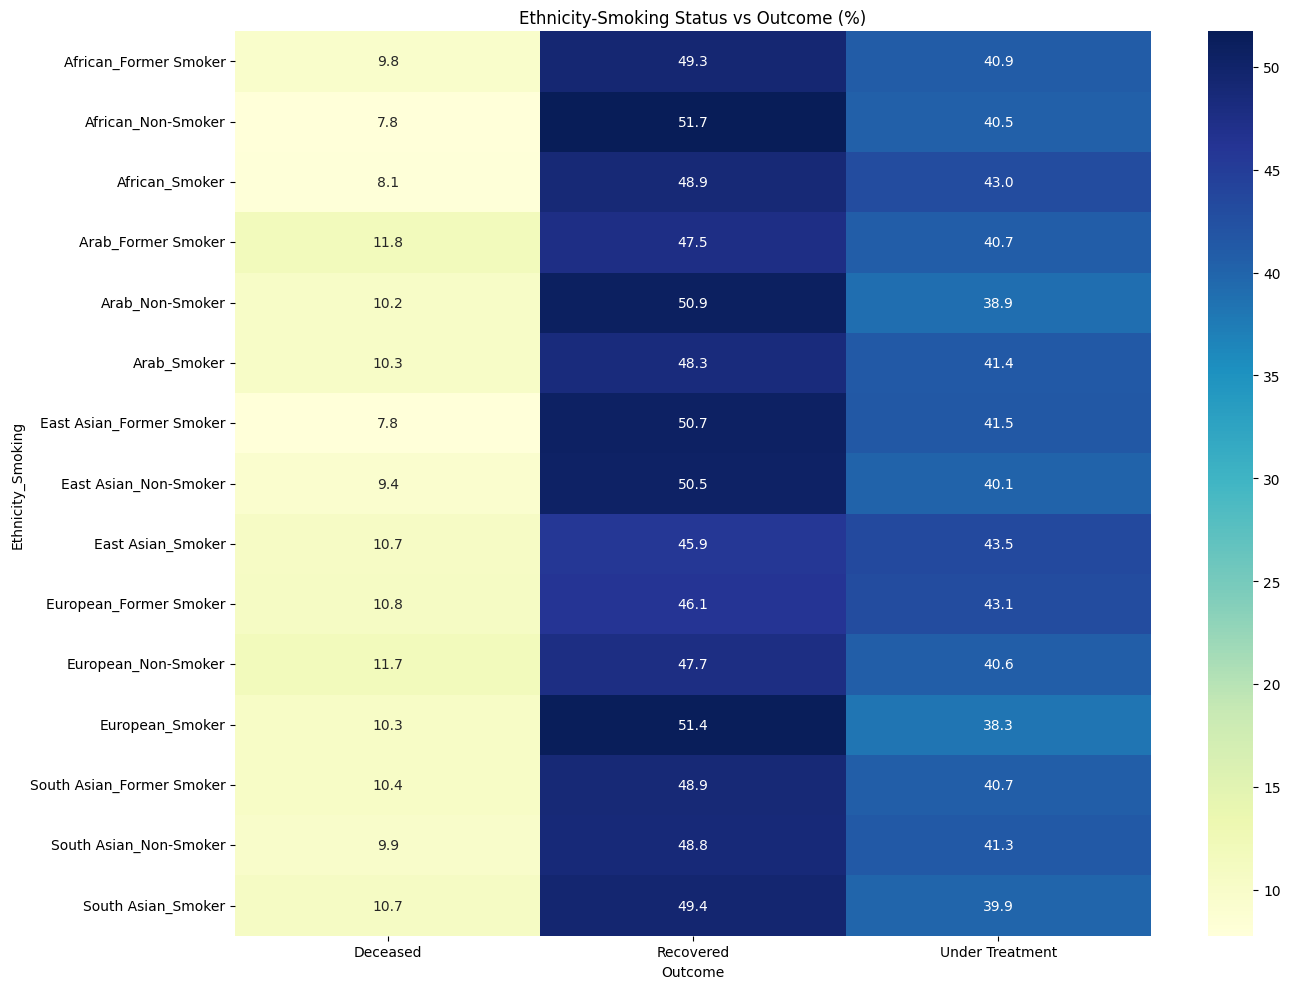

<Figure size 1400x1000 with 0 Axes>

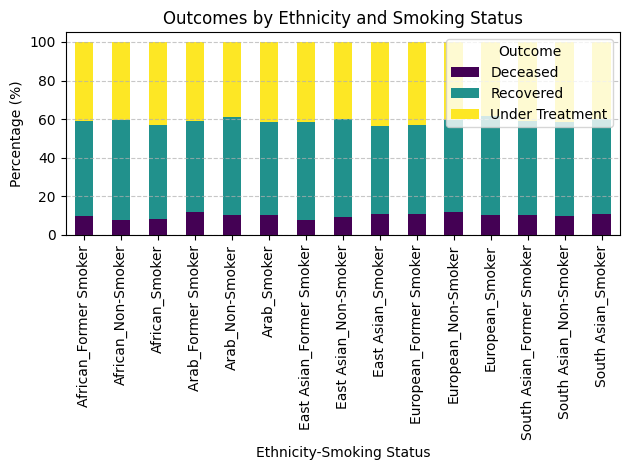


-------------------- Ethnicity-Smoking vs Outcome --------------------

Testing if the data is normally distributed:
Shapiro-Wilk Test: W=0.9234, p-value=0.005531
Normally distributed according to Shapiro-Wilk: False
D'Agostino-Pearson Test: k²=4.7196, p-value=0.094440
Normally distributed according to D'Agostino-Pearson: True
Kolmogorov-Smirnov Test: D=0.1088, p-value=0.621706
Normally distributed according to Kolmogorov-Smirnov: True


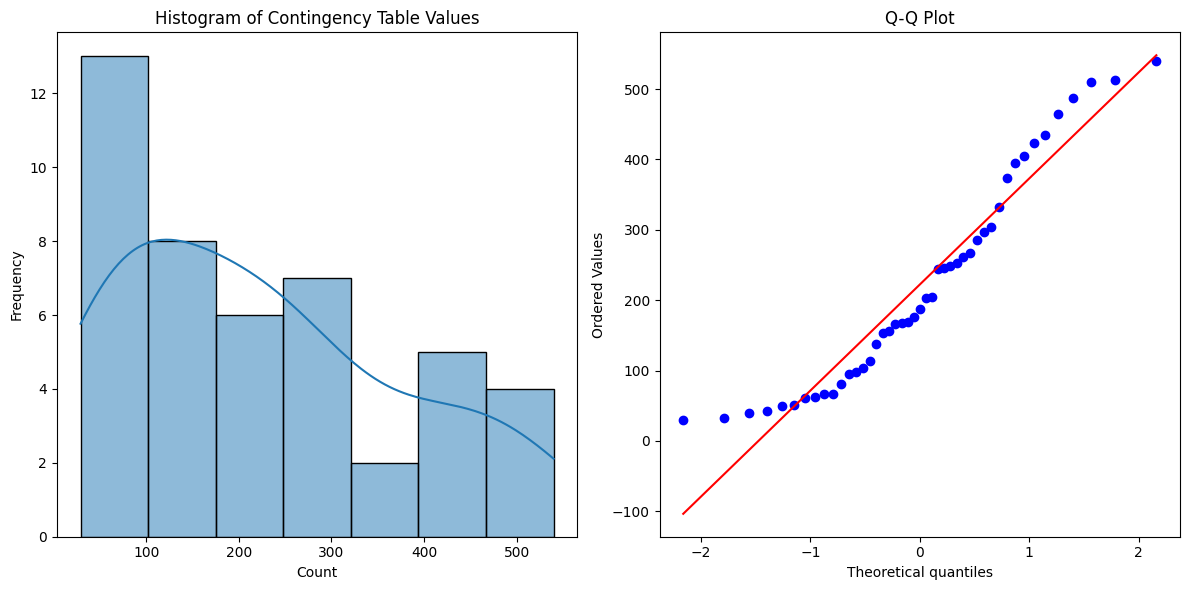


Overall assessment: Data is normally distributed.

Traditional Chi-square test results:
Chi-square value: 25.3881
p-value: 0.606638
Degrees of freedom: 28
Association is statistically significant (α=0.05): False

Conclusion: Using traditional chi-square test, the association is not statistically significant
(p-value = 0.606638, α=0.05)

COMPREHENSIVE ANALYSIS SUMMARY

SUMMARY OF STATISTICAL RELATIONSHIPS:
--------------------------------------------------------------------------------
1. There is no statistically significant relationship between ethnicity-smoking status and cancer type (p-value = 0.194394, using traditional chi-square test).
--------------------------------------------------------------------------------
2. There is no statistically significant relationship between cancer type and cancer stage (p-value = 0.784157, using traditional chi-square test).
--------------------------------------------------------------------------------
3. There is no statistically significan

In [ ]:
# Comprehensive Cancer Data Analysis Pipeline
# Analyzing relationships between ethnicity, smoking status, cancer types, stages, treatments, and outcomes

# 1. SETUP AND DATA LOADING
# ------------------------------------------------------------------------

# Install necessary packages
!pip install pyspark scipy statsmodels

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, concat_ws, lit
import io
from google.colab import files
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact
import warnings
warnings.filterwarnings('ignore')

# Define a function to test normality and choose appropriate statistical test
def test_normality_and_association(contingency_table, test_name=""):
    """
    Test if data is normally distributed and perform appropriate statistical test.
    Returns results dictionary with test statistics and conclusion.
    """
    print(f"\n{'-'*20} {test_name} {'-'*20}")

    # Convert the contingency table to a 1D array for normality tests
    data_array = contingency_table.values.flatten()

    # Skip tests if there's not enough data
    if len(data_array) < 3:
        print("Not enough data for normality testing.")
        return {"is_normal": False, "p_value": None, "test_used": None, "is_significant": None}

    # Check if all values are the same
    if np.std(data_array) == 0:
        print("All values are identical. Normality tests are not applicable.")
        return {"is_normal": False, "p_value": None, "test_used": None, "is_significant": None}

    # Perform normality tests
    print("\nTesting if the data is normally distributed:")

    normality_results = {}

    # Try Shapiro-Wilk test (for n < 2000)
    if len(data_array) < 2000:
        try:
            shapiro_test = stats.shapiro(data_array)
            normality_results["shapiro"] = {
                "statistic": shapiro_test.statistic,
                "p_value": shapiro_test.pvalue,
                "is_normal": shapiro_test.pvalue > 0.05
            }
            print(f"Shapiro-Wilk Test: W={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.6f}")
            print(f"Normally distributed according to Shapiro-Wilk: {shapiro_test.pvalue > 0.05}")
        except Exception as e:
            print(f"Shapiro-Wilk test failed: {e}")

    # D'Agostino-Pearson test
    try:
        k2, p_dagostino = stats.normaltest(data_array)
        normality_results["dagostino"] = {
            "statistic": k2,
            "p_value": p_dagostino,
            "is_normal": p_dagostino > 0.05
        }
        print(f"D'Agostino-Pearson Test: k²={k2:.4f}, p-value={p_dagostino:.6f}")
        print(f"Normally distributed according to D'Agostino-Pearson: {p_dagostino > 0.05}")
    except Exception as e:
        print(f"D'Agostino-Pearson test failed: {e}")

    # Kolmogorov-Smirnov test
    try:
        ks_test = stats.kstest(data_array, 'norm', args=(np.mean(data_array), np.std(data_array, ddof=1)))
        normality_results["ks"] = {
            "statistic": ks_test.statistic,
            "p_value": ks_test.pvalue,
            "is_normal": ks_test.pvalue > 0.05
        }
        print(f"Kolmogorov-Smirnov Test: D={ks_test.statistic:.4f}, p-value={ks_test.pvalue:.6f}")
        print(f"Normally distributed according to Kolmogorov-Smirnov: {ks_test.pvalue > 0.05}")
    except Exception as e:
        print(f"Kolmogorov-Smirnov test failed: {e}")

    # Visualize the distribution
    plt.figure(figsize=(12, 6))

    # Histogram with normal curve
    plt.subplot(1, 2, 1)
    sns.histplot(data_array, kde=True)
    plt.title('Histogram of Contingency Table Values')
    plt.xlabel('Count')
    plt.ylabel('Frequency')

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(data_array, plot=plt)
    plt.title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # Determine if data is normally distributed (if at least 2 tests agree)
    normal_count = sum([
        normality_results.get("shapiro", {}).get("is_normal", False),
        normality_results.get("dagostino", {}).get("is_normal", False),
        normality_results.get("ks", {}).get("is_normal", False)
    ])

    is_normal = normal_count >= 2 and len(normality_results) >= 2

    print(f"\nOverall assessment: Data is {'normally' if is_normal else 'not normally'} distributed.")

    # Run statistical tests
    result = {}
    result["is_normal"] = is_normal

    # Traditional Chi-Square Test
    try:
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print("\nTraditional Chi-square test results:")
        print(f"Chi-square value: {chi2:.4f}")
        print(f"p-value: {p:.6f}")
        print(f"Degrees of freedom: {dof}")
        print(f"Association is statistically significant (α=0.05): {p < 0.05}")

        result["chi2"] = {"statistic": chi2, "p_value": p, "dof": dof, "is_significant": p < 0.05}
    except Exception as e:
        print(f"Chi-square test failed: {e}")

    # For non-normal data, use non-parametric test
    if not is_normal:
        try:
            # Monte Carlo simulation for chi-square
            chi2_mc, p_mc, dof_mc, expected_mc = chi2_contingency(contingency_table, simulate_p_value=True, iterations=10000)
            print("\nNon-parametric Chi-square test (Monte Carlo simulation):")
            print(f"Chi-square value: {chi2_mc:.4f}")
            print(f"Monte Carlo p-value: {p_mc:.6f}")
            print(f"Degrees of freedom: {dof_mc}")
            print(f"Association is statistically significant (α=0.05): {p_mc < 0.05}")

            result["non_parametric"] = {"statistic": chi2_mc, "p_value": p_mc, "dof": dof_mc, "is_significant": p_mc < 0.05}
            result["test_used"] = "non_parametric"
            result["final_p_value"] = p_mc
            result["is_significant"] = p_mc < 0.05
        except Exception as e:
            print(f"Non-parametric Chi-square test failed: {e}")
            # Fall back to traditional chi-square if available
            if "chi2" in result:
                result["test_used"] = "chi2"
                result["final_p_value"] = result["chi2"]["p_value"]
                result["is_significant"] = result["chi2"]["is_significant"]
    else:
        # Use traditional chi-square for normal data
        if "chi2" in result:
            result["test_used"] = "chi2"
            result["final_p_value"] = result["chi2"]["p_value"]
            result["is_significant"] = result["chi2"]["is_significant"]

    # Fisher's exact test for small tables
    if contingency_table.shape[0] <= 2 and contingency_table.shape[1] <= 2:
        try:
            odds_ratio, p_fisher = fisher_exact(contingency_table)
            print("\nFisher's exact test results:")
            print(f"Odds ratio: {odds_ratio:.4f}")
            print(f"p-value: {p_fisher:.6f}")
            print(f"Association is statistically significant (α=0.05): {p_fisher < 0.05}")

            result["fisher"] = {"odds_ratio": odds_ratio, "p_value": p_fisher, "is_significant": p_fisher < 0.05}

            # For very small samples, prefer Fisher's exact test
            if contingency_table.size <= 20:  # Total cells <= 20
                result["test_used"] = "fisher"
                result["final_p_value"] = p_fisher
                result["is_significant"] = p_fisher < 0.05
        except Exception as e:
            print(f"Fisher's exact test failed: {e}")

    # Final conclusion
    test_name_map = {
        "chi2": "traditional chi-square test",
        "non_parametric": "non-parametric chi-square test with Monte Carlo simulation",
        "fisher": "Fisher's exact test"
    }

    test_used = result.get("test_used")
    if test_used:
        test_name = test_name_map.get(test_used, test_used)
        p_value = result.get("final_p_value")
        is_significant = result.get("is_significant")

        print(f"\nConclusion: Using {test_name}, the association is {'statistically significant' if is_significant else 'not statistically significant'}")
        print(f"(p-value = {p_value:.6f}, α=0.05)")

    return result

# Function to handle file upload
def get_csv_data():
    """
    Upload CSV file through Google Colab interface.
    Returns pandas DataFrame and filename.
    """
    print("Please upload your CSV file...")
    uploaded = files.upload()  # This will prompt for file upload

    for filename in uploaded.keys():
        print(f"Uploaded {filename} ({len(uploaded[filename])} bytes)")
        # Create a pandas DataFrame from the uploaded file
        pandas_df = pd.read_csv(io.BytesIO(uploaded[filename]))
        return pandas_df, filename

    return None, None

# Function to load data with file path option
def load_data():
    """
    Load data either from upload or specified path.
    Returns DataFrame.
    """
    print("Choose data loading method:")
    print("1. Upload CSV file")
    print("2. Use file path")

    choice = input("Enter your choice (1 or 2): ")

    if choice == "1":
        # Get data through upload
        df_pandas, filename = get_csv_data()
    elif choice == "2":
        # Use file path
        file_path = input("Enter file path: ")
        try:
            df_pandas = pd.read_csv(file_path)
            filename = file_path.split("/")[-1]
            print(f"Successfully loaded {filename}")
        except Exception as e:
            print(f"Error loading file: {e}")
            print("Falling back to upload method...")
            df_pandas, filename = get_csv_data()
    else:
        print("Invalid choice. Falling back to upload method...")
        df_pandas, filename = get_csv_data()

    return df_pandas, filename

# Create a Spark session
spark = SparkSession.builder \
    .appName("Cancer Data Analysis") \
    .getOrCreate()

# Get data
print("LOADING DATA")
print("="*50)
print("For Google Colab, you can either upload the file directly or provide the path.")
print("Default path for uploaded files: '_cancer_dataset_uae.csv'")
print("If using from Google Drive, first mount your drive with:")
print("from google.colab import drive")
print("drive.mount('/content/drive')")
print("Then use path like: '/content/drive/My Drive/_cancer_dataset_uae.csv'")

df_pandas, filename = load_data()

# Display basic information about the dataset
print("\nDataset Info:")
print(f"Number of rows: {df_pandas.shape[0]}")
print(f"Number of columns: {df_pandas.shape[1]}")

# Check variable values
print("\nChecking expected variable values:")
print(f"Ethnicity unique values: {df_pandas['Ethnicity'].unique()}")
print(f"Smoking_Status unique values: {df_pandas['Smoking_Status'].unique()}")
print(f"Cancer_Type unique values: {df_pandas['Cancer_Type'].unique()}")
print(f"Cancer_Stage unique values: {df_pandas['Cancer_Stage'].unique()}")
print(f"Treatment_Type unique values: {df_pandas['Treatment_Type'].unique()}")
print(f"Outcome unique values: {df_pandas['Outcome'].unique()}")

# Convert pandas DataFrame to Spark DataFrame
df = spark.createDataFrame(df_pandas)
print("\nDataFrame created in Spark successfully!")

# 2. CREATING NEW COMBINED VARIABLES
# ------------------------------------------------------------------------
print("\n" + "="*50)
print("CREATING COMBINED VARIABLES")
print("="*50)

# Create Ethnicity-Smoking combined variable
df = df.withColumn("Ethnicity_Smoking",
                  concat_ws("_", col("Ethnicity"), col("Smoking_Status")))

# Create Cancer_Type_Stage combined variable
df = df.withColumn("Cancer_Type_Stage",
                  concat_ws("_Stage_", col("Cancer_Type"), col("Cancer_Stage")))

# Convert back to pandas for analysis
df_pandas = df.toPandas()

# 3. ANALYSIS PART 1: ETHNICITY-SMOKING VS CANCER TYPE
# ------------------------------------------------------------------------
print("\n" + "="*50)
print("ANALYSIS 1: ETHNICITY-SMOKING VS CANCER TYPE")
print("="*50)

# Create contingency table
cross_tab1 = pd.crosstab(df_pandas['Ethnicity_Smoking'], df_pandas['Cancer_Type'])
print("\nContingency Table (Ethnicity_Smoking vs Cancer_Type):")
print(cross_tab1)

# Calculate percentages
percentage_tab1 = pd.crosstab(
    df_pandas['Ethnicity_Smoking'],
    df_pandas['Cancer_Type'],
    normalize='index'
) * 100

print("\nPercentage Table (row percentages):")
print(percentage_tab1.round(2))

# Visualization
plt.figure(figsize=(16, 10))
sns.heatmap(percentage_tab1, annot=True, cmap="YlGnBu", fmt='.1f')
plt.title('Ethnicity-Smoking Status vs Cancer Type (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistical testing
ethn_smoking_cancer_result = test_normality_and_association(
    cross_tab1,
    "Ethnicity-Smoking Status vs Cancer Type"
)

# 4. ANALYSIS PART 2: CANCER TYPE VS CANCER STAGE
# ------------------------------------------------------------------------
print("\n" + "="*50)
print("ANALYSIS 2: CANCER TYPE VS CANCER STAGE")
print("="*50)

# Create contingency table
cross_tab2 = pd.crosstab(df_pandas['Cancer_Type'], df_pandas['Cancer_Stage'])
print("\nContingency Table (Cancer_Type vs Cancer_Stage):")
print(cross_tab2)

# Calculate percentages
percentage_tab2 = pd.crosstab(
    df_pandas['Cancer_Type'],
    df_pandas['Cancer_Stage'],
    normalize='index'
) * 100

print("\nPercentage Table (row percentages):")
print(percentage_tab2.round(2))

# Visualization
plt.figure(figsize=(14, 8))
sns.heatmap(percentage_tab2, annot=True, cmap="YlGnBu", fmt='.1f')
plt.title('Cancer Type vs Cancer Stage (%)')
plt.tight_layout()
plt.show()

# Stacked bar chart
plt.figure(figsize=(14, 8))
percentage_tab2.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('Cancer Type')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Cancer Stages by Cancer Type')
plt.legend(title='Cancer Stage')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Statistical testing
cancer_type_stage_result = test_normality_and_association(
    cross_tab2,
    "Cancer Type vs Cancer Stage"
)

# 5. ANALYSIS PART 3: CANCER TYPE-STAGE VS TREATMENT TYPE
# ------------------------------------------------------------------------
print("\n" + "="*50)
print("ANALYSIS 3: CANCER TYPE-STAGE VS TREATMENT TYPE")
print("="*50)

# Create contingency table
cross_tab3 = pd.crosstab(df_pandas['Cancer_Type_Stage'], df_pandas['Treatment_Type'])
print("\nContingency Table (Cancer_Type_Stage vs Treatment_Type):")
print(cross_tab3)

# Calculate percentages
percentage_tab3 = pd.crosstab(
    df_pandas['Cancer_Type_Stage'],
    df_pandas['Treatment_Type'],
    normalize='index'
) * 100

print("\nPercentage Table (row percentages):")
print(percentage_tab3.round(2))

# Visualization - this might be a large table, so let's create a filtered version for visualization
# Get the top 15 most common cancer type-stage combinations
top_cancer_type_stages = df_pandas['Cancer_Type_Stage'].value_counts().head(15).index

# Filter the contingency tables for these values
filtered_percentage_tab3 = percentage_tab3.loc[top_cancer_type_stages]

plt.figure(figsize=(16, 12))
sns.heatmap(filtered_percentage_tab3, annot=True, cmap="YlGnBu", fmt='.1f')
plt.title('Top 15 Cancer Type-Stages vs Treatment Type (%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Statistical testing
cancer_typestage_treatment_result = test_normality_and_association(
    cross_tab3,
    "Cancer Type-Stage vs Treatment Type"
)

# 6. ANALYSIS PART 4: TREATMENT TYPE VS OUTCOME
# ------------------------------------------------------------------------
print("\n" + "="*50)
print("ANALYSIS 4: TREATMENT TYPE VS OUTCOME")
print("="*50)

# Create contingency table
cross_tab4 = pd.crosstab(df_pandas['Treatment_Type'], df_pandas['Outcome'])
print("\nContingency Table (Treatment_Type vs Outcome):")
print(cross_tab4)

# Calculate percentages
percentage_tab4 = pd.crosstab(
    df_pandas['Treatment_Type'],
    df_pandas['Outcome'],
    normalize='index'
) * 100

print("\nPercentage Table (row percentages):")
print(percentage_tab4.round(2))

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(percentage_tab4, annot=True, cmap="YlGnBu", fmt='.1f')
plt.title('Treatment Type vs Outcome (%)')
plt.tight_layout()
plt.show()

# Stacked bar chart
plt.figure(figsize=(12, 8))
percentage_tab4.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('Treatment Type')
plt.ylabel('Percentage (%)')
plt.title('Outcomes by Treatment Type')
plt.legend(title='Outcome')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Statistical testing
treatment_outcome_result = test_normality_and_association(
    cross_tab4,
    "Treatment Type vs Outcome"
)

# 7. FINAL ANALYSIS: CONNECTING ETHNICITY-SMOKING TO OUTCOMES
# ------------------------------------------------------------------------
print("\n" + "="*50)
print("FINAL ANALYSIS: ETHNICITY-SMOKING VS OUTCOME")
print("="*50)

# Create contingency table
cross_tab5 = pd.crosstab(df_pandas['Ethnicity_Smoking'], df_pandas['Outcome'])
print("\nContingency Table (Ethnicity_Smoking vs Outcome):")
print(cross_tab5)

# Calculate percentages
percentage_tab5 = pd.crosstab(
    df_pandas['Ethnicity_Smoking'],
    df_pandas['Outcome'],
    normalize='index'
) * 100

print("\nPercentage Table (row percentages):")
print(percentage_tab5.round(2))

# Visualization
plt.figure(figsize=(14, 10))
sns.heatmap(percentage_tab5, annot=True, cmap="YlGnBu", fmt='.1f')
plt.title('Ethnicity-Smoking Status vs Outcome (%)')
plt.tight_layout()
plt.show()

# Stacked bar chart
plt.figure(figsize=(14, 10))
percentage_tab5.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('Ethnicity-Smoking Status')
plt.ylabel('Percentage (%)')
plt.title('Outcomes by Ethnicity and Smoking Status')
plt.legend(title='Outcome')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Statistical testing
ethnicity_smoking_outcome_result = test_normality_and_association(
    cross_tab5,
    "Ethnicity-Smoking vs Outcome"
)

# 8. COMPREHENSIVE SUMMARY
# ------------------------------------------------------------------------
print("\n" + "="*50)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*50)

# Function to describe relationship based on statistical test
def describe_relationship(result, relationship_name):
    """Return a description of the relationship based on statistical test results."""
    if not result or "final_p_value" not in result:
        return f"The relationship between {relationship_name} could not be determined."

    test_name_map = {
        "chi2": "traditional chi-square test",
        "non_parametric": "non-parametric chi-square test",
        "fisher": "Fisher's exact test"
    }

    test_used = result.get("test_used", "unknown test")
    test_name = test_name_map.get(test_used, test_used)
    p_value = result.get("final_p_value", 0)
    is_significant = result.get("is_significant", False)

    if is_significant:
        return f"There is a statistically significant relationship between {relationship_name} (p-value = {p_value:.6f}, using {test_name})."
    else:
        return f"There is no statistically significant relationship between {relationship_name} (p-value = {p_value:.6f}, using {test_name})."

# Print summary of all relationships
print("\nSUMMARY OF STATISTICAL RELATIONSHIPS:")
print("-" * 80)
print("1. " + describe_relationship(ethn_smoking_cancer_result, "ethnicity-smoking status and cancer type"))
print("-" * 80)
print("2. " + describe_relationship(cancer_type_stage_result, "cancer type and cancer stage"))
print("-" * 80)
print("3. " + describe_relationship(cancer_typestage_treatment_result, "cancer type-stage and treatment type"))
print("-" * 80)
print("4. " + describe_relationship(treatment_outcome_result, "treatment type and outcome"))
print("-" * 80)
print("5. " + describe_relationship(ethnicity_smoking_outcome_result, "ethnicity-smoking status and outcome"))
print("-" * 80)

# Find highest risk combinations
# Get smoking-ethnicity groups with highest "Deceased" percentage
if 'Deceased' in percentage_tab5.columns:
    highest_deceased = percentage_tab5['Deceased'].sort_values(ascending=False).head(3)
    print("\nEthnicity-Smoking Groups with Highest Mortality Rates:")
    for group, rate in highest_deceased.items():
        print(f"- {group}: {rate:.2f}%")

# Get smoking-ethnicity groups with highest "Recovered" percentage
if 'Recovered' in percentage_tab5.columns:
    highest_recovered = percentage_tab5['Recovered'].sort_values(ascending=False).head(3)
    print("\nEthnicity-Smoking Groups with Highest Recovery Rates:")
    for group, rate in highest_recovered.items():
        print(f"- {group}: {rate:.2f}%")

# Connect ethnicity-smoking to cancer types to treatment to outcomes
print("\nCONCLUSION:")
print("-" * 80)
print("This analysis examined the relationships between ethnicity, smoking status, cancer characteristics, ")
print("treatments, and outcomes. The pathway from ethnicity and smoking habits to health outcomes ")
print("was traced through several intermediate relationships.")
print("\nKEY FINDINGS:")

# Extract key cancer types for each ethnicity-smoking group
def get_top_cancer_types(ethnicity_smoking_group):
    """Return the top 2 cancer types for a given ethnicity-smoking group."""
    if ethnicity_smoking_group not in percentage_tab1.index:
        return []

    top_types = percentage_tab1.loc[ethnicity_smoking_group].sort_values(ascending=False).head(2)
    return [(cancer_type, rate) for cancer_type, rate in top_types.items()]

# Find worst outcome groups and trace their pathway
if 'Deceased' in percentage_tab5.columns:
    worst_group = highest_deceased.index[0]
    worst_rate = highest_deceased.iloc[0]

    print(f"\n1. {worst_group} had the highest mortality rate at {worst_rate:.2f}%")

    # Find their most common cancer types
    top_cancers = get_top_cancer_types(worst_group)
    if top_cancers:
        print(f"   This group most commonly developed:")
        for cancer, rate in top_cancers:
            print(f"   - {cancer} cancer ({rate:.2f}%)")

            # Find most common stage for this cancer
            if cancer in percentage_tab2.index:
                top_stage = percentage_tab2.loc[cancer].sort_values(ascending=False).index[0]
                stage_rate = percentage_tab2.loc[cancer, top_stage]
                print(f"     - Most commonly diagnosed at Stage {top_stage} ({stage_rate:.2f}%)")

                # Find most common treatment for this cancer-stage
                cancer_stage = f"{cancer}_Stage_{top_stage}"
                if cancer_stage in percentage_tab3.index:
                    top_treatment = percentage_tab3.loc[cancer_stage].sort_values(ascending=False).index[0]
                    treatment_rate = percentage_tab3.loc[cancer_stage, top_treatment]
                    print(f"       - Most commonly treated with {top_treatment} ({treatment_rate:.2f}%)")

# Find best outcome groups and trace their pathway
if 'Recovered' in percentage_tab5.columns:
    best_group = highest_recovered.index[0]
    best_rate = highest_recovered.iloc[0]

    print(f"\n2. {best_group} had the highest recovery rate at {best_rate:.2f}%")

    # Find their most common cancer types
    top_cancers = get_top_cancer_types(best_group)
    if top_cancers:
        print(f"   This group most commonly developed:")
        for cancer, rate in top_cancers:
            print(f"   - {cancer} cancer ({rate:.2f}%)")

            # Find most common stage for this cancer
            if cancer in percentage_tab2.index:
                top_stage = percentage_tab2.loc[cancer].sort_values(ascending=False).index[0]
                stage_rate = percentage_tab2.loc[cancer, top_stage]
                print(f"     - Most commonly diagnosed at Stage {top_stage} ({stage_rate:.2f}%)")

                # Find most common treatment for this cancer-stage
                cancer_stage = f"{cancer}_Stage_{top_stage}"
                if cancer_stage in percentage_tab3.index:
                    top_treatment = percentage_tab3.loc[cancer_stage].sort_values(ascending=False).index[0]
                    treatment_rate = percentage_tab3.loc[cancer_stage, top_treatment]
                    print(f"       - Most commonly treated with {top_treatment} ({treatment_rate:.2f}%)")

print("\nPATHWAY SUMMARY:")
print("This analysis reveals how ethnicity and smoking status may influence cancer outcomes through")
print("their association with specific cancer types, which in turn affect staging, treatment options,")
print("and ultimately patient outcomes. The statistical relationships identified provide insight into")
print("potential risk factors and treatment efficacy across different population groups.")

# Stop the Spark session
spark.stop()